### Librerías

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from keras import layers

### Lectura de datos

In [54]:
def load_data(path):
    """
    Función para cargar los datos
    """
    data=pd.read_csv(path,index_col=0)
    X = data.drop(columns='Defaulted Payment')
    Y= data['Defaulted Payment']
    return X, Y, data

### Preprocesamiento de datos

In [55]:
def preprocess_data(X_train, X_test):
    """
    Preprocesamiento de los datos
    """

    # Estandarizar los datos
    # Datos quedan con media 0 desviación 1
    scaler = StandardScaler().fit(X_train)
    X_train_standard = scaler.transform(X_train)
    X_test_standard = scaler.transform(X_test)
    
    return X_train_standard , X_test_standard

In [56]:
def augment_data(X_train, Y_train):
    """
    Aumento de datos de la clase minoritaria (Defaulted Payment = 1)
    """
    # Repetir varias veces los datos de la clase minoritaria
    # Seleccionar los datos de la clase minoritaria
    minority_class = X_train[Y_train == 1]
    n_samples = len(X_train[Y_train == 0]) - len(minority_class) 
    random_minority_class = minority_class.sample(n=n_samples, replace=True)
    # Aumentar los datos de la clase minoritaria
    X_train_augmented = np.concatenate((X_train, random_minority_class), axis=0)
    Y_train_augmented = np.concatenate((Y_train, np.ones(len(random_minority_class))), axis=0)
    
    return X_train_augmented, Y_train_augmented

### Arquitectura

In [57]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, Conv1D, MaxPooling1D, Flatten

def get_model():
    """
    Arquitectura de la red
    """
    # Definir la entrada para los estados de pago
    pay_status_input = Input(shape=(6,))
    pay_status_input_expanded = tf.expand_dims(pay_status_input, axis=-1)

    # Procesar los estados de pago en una red neuronal convolucional 1D
    pay_status_output = Conv1D(32, 3, activation='relu', padding='same')(pay_status_input_expanded)
    pay_status_output = MaxPooling1D(2)(pay_status_output)
    pay_status_output = Conv1D(16, 3, activation='relu', padding='same')(pay_status_output)
    pay_status_output = MaxPooling1D(2)(pay_status_output)
    pay_status_output = Flatten()(pay_status_output)
    pay_status_output = Dropout(0.5)(pay_status_output)

    # Definir la entrada para las características de crédito
    credit_input = Input(shape=(3,))
    credit_output = Dense(16, activation='relu')(credit_input)
    credit_output = Dropout(0.5)(credit_output)
    credit_output = Dense(8, activation='relu')(credit_output)
    credit_output = Dropout(0.5)(credit_output)

    # Definir la entrada para las características personales
    personal_input = Input(shape=(12,))
    personal_output = Dense(16, activation='relu')(personal_input)
    personal_output = Dropout(0.5)(personal_output)
    personal_output = Dense(8, activation='relu')(personal_output)
    personal_output = Dropout(0.5)(personal_output)

    # Concatenar las salidas de las tres subredes
    concatenated = concatenate([pay_status_output, credit_input, personal_input])

    # Definir la red neuronal final
    output = Dense(32, activation='relu')(concatenated)
    output = Dropout(0.5)(output)
    output = Dense(16, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(8, activation='relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(1, activation='sigmoid')(output)

    # Definir el modelo
    model = Model(inputs=[pay_status_input, credit_input, personal_input], outputs=output)

    # Compilar el modelo
    model.compile(
        optimizer=Adam(),
        #Binary _cross.. porque son solo 2 clases
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Resumen del modelo
    print(model.summary())

    return model

### Entrenamiento

In [58]:
def train_neural_network(model, X_train, y_train):
    """
    Entrenamiento del clasificador
    """

    checkpoint = ModelCheckpoint("model_reducido.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)    

    # Entrenar el modelo
    history = model.fit(
        x=[X_train[:, :6], X_train[:, 6:9], X_train[:, 9:]],
        y=y_train,
        epochs=100,
        batch_size=30000,
        validation_split=0.2,
        validation_batch_size=30000,
        callbacks=[checkpoint, early_stopping]
    )

    return history

### Métricas

In [59]:
def calculate_metrics(y_real, y_pred, labels):
    """
    Cálculo de métricas de evaluación del modelo
    """
    accuracy = accuracy_score(y_real, y_pred)
    print("Accuracy del modelo:", accuracy)

    print("\nInforme de clasificación:")
    print(classification_report(y_real, y_pred))

    # Matriz de confusión
    plt.figure()
    cm = confusion_matrix(y_real, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot()

In [60]:
def calculate_revenue(y_pred, data, p = 0.03, r = 0.3, threshold = 0.5):
    """
    Cálculo de los ingresos obtenidos por el modelo
    """

    temp_df = data.copy()
    y_pred = (y_pred >= threshold).astype(int)
    temp_df = temp_df[y_pred.flatten() == 0]
    temp_df['Average Debt'] = temp_df['Average Bill Amount'] - temp_df['Average Pay Amount']
    temp_df['Income'] = temp_df['Average Bill Amount'] * 6 * p * (1 - temp_df['Defaulted Payment'])
    temp_df['Loses'] = temp_df['Average Debt'] * temp_df['Defaulted Payment'] * (1 - r)
    temp_df['Revenue'] = temp_df['Income'] - temp_df['Loses']
    income = temp_df['Income'].sum()
    loses = temp_df['Loses'].sum()
    revenue = temp_df['Revenue'].sum()
    return revenue, income, loses

In [61]:
def find_best_threshold_by_revenue(y_all, data):
    """
    Encontrar el mejor umbral de decisión
    """
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0
    best_revenue = 0
    revenues = []
    for threshold in thresholds:
        current_revenue, _, _ = calculate_revenue(y_all, data, threshold=threshold)
        revenues.append(current_revenue)
        if current_revenue > best_revenue:
            best_revenue = current_revenue
            best_threshold = threshold

    plt.plot(thresholds, revenues)
    plt.xlabel('Threshold')
    plt.ylabel('Revenue')
    plt.title('Revenue vs Threshold')
    plt.text(best_threshold*1.1, best_revenue*0.8, f'Best threshold: {best_threshold:.2f}\nRevenue: {best_revenue:.2f}', fontsize=12)
    return best_threshold

### Visualización de resultados

In [62]:
def visualize_training(history):
    """
    Visualización del entrenamiento
    """
    # Generar y mostrar las curvas de pérdida versus epoch
    plt.figure()
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [63]:
def plot_roc_curve(y_real, y_pred):
    """
    Visualización de la curva ROC
    """
    fpr, tpr, _ = roc_curve(y_real, y_pred)
    auc = roc_auc_score(y_real, y_pred)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = {:.2f})".format(auc))
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

### Pipeline

In [64]:
def pipeline():
    """
    Pipeline para entrenar y evaluar el modelo
    """

    # Cargar las imágenes
    X, y, df = load_data('./datos_modelo.csv')

    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Aumentar los datos de la clase minoritaria
    X_train, y_train = augment_data(X_train, y_train)

    # Preprocesamiento de datos
    X_train_processed, X_test_processed = preprocess_data(X_train, X_test)

    # Entrenamiento del modelo
    model = get_model()
    history = train_neural_network(model, X_train_processed, y_train)

    # Hallar el umbral óptimo según revenue
    X_all = df.drop(columns='Defaulted Payment')
    X_all_processed = preprocess_data(X_all, X_all)[0]
    y_all = model.predict([X_all_processed[:, :6], X_all_processed[:, 6:9], X_all_processed[:, 9:]])
    best_threshold = find_best_threshold_by_revenue(y_all, df)
    print(f"Best threshold: {best_threshold}")

    # Predicciones en el conjunto de prueba
    y_pred = model.predict([X_test_processed[:, :6], X_test_processed[:, 6:9], X_test_processed[:, 9:]])
    y_pred = (y_pred > best_threshold)

    # Métricas de evaluación
    calculate_metrics(y_test, y_pred, ['Not Defaulted', 'Defaulted'])

    # Cálculo de los ingresos obtenidos por el modelo
    # La base (sin modelo) es $-4,003,108.40
    revenue, income, loses = calculate_revenue(y_all, df, threshold=best_threshold)
    print(f"Final revenue: ${revenue:,.2f} - Income: ${income:,.2f} - Loses: ${loses:,.2f}")

    # Visualización del entrenamiento
    visualize_training(history)

    # Curva ROC
    plot_roc_curve(y_test, y_pred)

/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 6)]                  0         []                            
                                                                                                  
 tf.expand_dims_4 (TFOpLamb  (None, 6, 1)                 0         ['input_13[0][0]']            
 da)                                                                                              
                                                                                                  
 conv1d_8 (Conv1D)           (None, 6, 32)                128       ['tf.expand_dims_4[0][0]']    
                                                                                                  
 max_pooling1d_8 (MaxPoolin  (None, 3, 32)                0         ['conv1d_8[0][0]']      

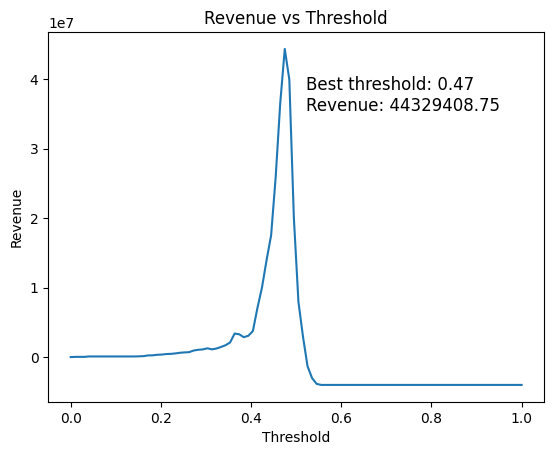

<Figure size 640x480 with 0 Axes>

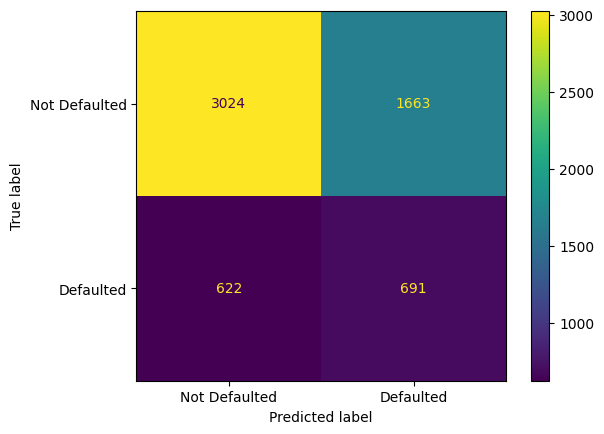

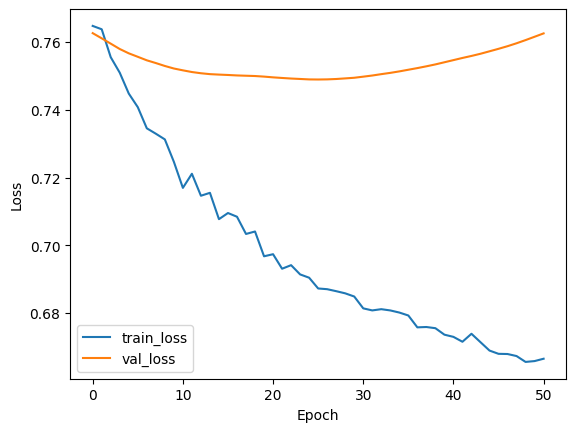

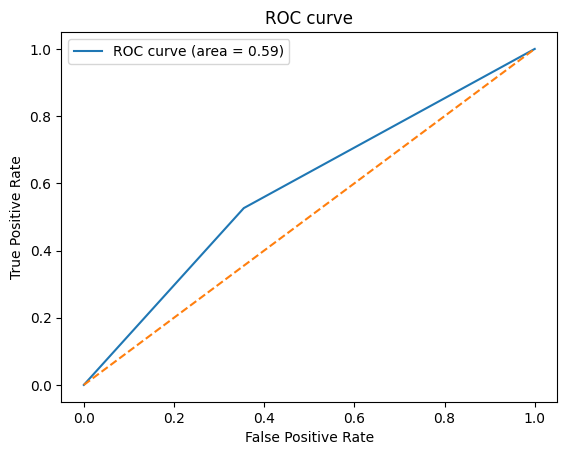

In [65]:
pipeline()